## Install Desired Libraries

In [1]:
%pip install peft==0.4.0 datasets transformers rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 3.7 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=52232045b0182b6def39e569d5980fde49bd518aecfa54b6e14bc3efc176d23a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


## Install Desired Libraries

In [2]:
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
import transformers
from peft import LoraConfig, get_peft_model
from transformers import GPT2Tokenizer
from rouge_score import rouge_scorer
import torch
from peft import PeftModel
import time
from transformers import EarlyStoppingCallback
from transformers import DataCollatorForLanguageModeling


## Load the Model and the Dataset

In [3]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

data = load_dataset("cnn_dailymail", "3.0.0")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
tokenizer.pad_token = tokenizer.eos_token
print(data)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


## Load the Dataset

In [6]:
train_data = data['train']
test_data = data['test']
validation_data=data['validation']

# load 10 percent of the dataset
train_size = int(0.1 * len(train_data))
test_size = int(0.1 * len(test_data))
validation_size = int(0.1 * len(validation_data))

train_sample = train_data.select(range(train_size))
test_sample = test_data.select(range(test_size))
validation_sample = validation_data.select(range(validation_size))

In [7]:
print(len(train_sample))
print(len(test_sample))
print(len(validation_sample))

28711
1149
1336


## Preprocess the Data

In [8]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["article"], max_length=512, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_data_train =train_sample.map(preprocess_function, batched=True)
tokenized_data_test =test_sample.map(preprocess_function, batched=True)
tokenized_data_validation =validation_sample.map(preprocess_function, batched=True)

Map:   0%|          | 0/28711 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1149 [00:00<?, ? examples/s]

Map:   0%|          | 0/1336 [00:00<?, ? examples/s]

## Declare the LORA Configuration

In [9]:
lora_config = LoraConfig(
    r=4,  
    lora_alpha=32,  
    target_modules=["c_attn"], 
    lora_dropout=0.1, 
    bias="none", 
    task_type="CAUSAL_LM" 
)

## Print the Parameters

In [10]:
peft_model = get_peft_model(foundation_model, lora_config)
total_params = sum(p.numel() for p in peft_model.parameters())
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

/opt/conda/lib/python3.10/site-packages/peft/tuners/lora.py:299: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Total parameters: 124587264
Trainable parameters: 147456


In [11]:
peft_model.add_adapter(peft_config=lora_config, adapter_name="t2")

In [16]:
# Define the output directory where the fine-tuned model will be saved.
output_directory = "./peft_gpt2_finetuned_model"
start_time=time.time()

# Define the training arguments.
training_args = TrainingArguments(
    output_dir=output_directory,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_steps=200,
    save_steps=500,
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    report_to="none",
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    greater_is_better=False,
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Initialize the Trainer.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_data_train,
    eval_dataset=tokenized_data_validation,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)



In [18]:
peft_model.save_pretrained(output_directory)


In [19]:
# Start training the LoRA-adapted GPT-2 model.
trainer.train()
test_results = trainer.evaluate(tokenized_data_test)

# Print the evaluation results, which include loss
print("Test results:", test_results)

Step,Training Loss,Validation Loss
500,3.107000,3.043425
1000,3.064100,3.042688
1500,3.072900,3.041061
2000,3.060000,3.039882
2500,3.048300,3.039144
3000,3.055000,3.040625
3500,3.072700,3.035505
4000,3.027600,3.038156
4500,3.045300,3.037278
5000,3.031600,3.039728


TypeError: 'method' object is not subscriptable

In [20]:
end_time=time.time()
print("Time taken", end_time-start_time)

Time taken 1652.5358126163483


In [21]:
# Evaluation Loss and ROUGE Scoring
def compute_rouge(preds, refs):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = [scorer.score(ref, pred) for ref, pred in zip(refs, preds)]
    avg_scores = {k: sum([score[k].fmeasure for score in scores]) / len(scores) for k in scores[0]}
    return avg_scores

# Generate Predictions for ROUGE Evaluation
def evaluate_model():
    eval_loss = trainer.evaluate()['eval_loss']
    print(f"Evaluation Loss: {eval_loss}")

    test_preds = []
    test_refs = [example["highlights"] for example in test_sample]

    # Ensure peft_model LoRA layers are active during generation
    peft_model.eval()  # Set the model to evaluation mode
    for example in tokenized_data_test:
        inputs = torch.tensor(example["input_ids"]).unsqueeze(0).to(peft_model.device)
        attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(peft_model.device)

        with torch.no_grad():
            outputs = peft_model.base_model.generate(
                inputs,
                attention_mask=attention_mask,
                max_length=513,
                pad_token_id=tokenizer.eos_token_id
            )
        test_preds.append(tokenizer.decode(outputs[0][:128], skip_special_tokens=True))

    rouge_scores = compute_rouge(test_preds, test_refs)
    print("ROUGE Scores:", rouge_scores)

# Run the evaluation
evaluate_model()

Evaluation Loss: 3.0397279262542725
ROUGE Scores: {'rouge1': 0.28124062631288177, 'rouge2': 0.11407364784042123, 'rougeL': 0.18764651661704718}


In [22]:
# Number of parameters
num_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

# Estimate GPU compute (in FLOPs)
flops = 2 * num_params * (training_args.per_device_train_batch_size * training_args.num_train_epochs)
print(f"Estimated FLOPs: {flops}")

# GPU memory usage
gpu_memory = torch.cuda.memory_allocated() / (1024**2)  # Convert to MB
print(f"GPU memory allocated: {gpu_memory:.2f} MB")


Number of trainable parameters: 294912
Estimated FLOPs: 7077888
GPU memory allocated: 507.19 MB


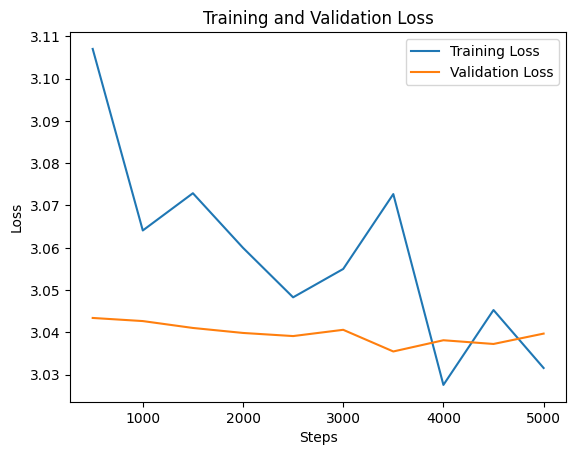

In [1]:
import matplotlib.pyplot as plt

steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

training_loss = [3.107000, 3.064100, 3.072900, 3.060000, 3.048300, 3.055000, 3.072700, 3.027600, 3.045300, 3.031600]

validation_loss = [3.043425, 3.042688, 3.041061, 3.039882, 3.039144, 3.040625, 3.035505, 3.038156, 3.037278, 3.039728]

# Plot the training and validation loss
plt.plot(steps, training_loss, label="Training Loss")
plt.plot(steps, validation_loss, label="Validation Loss")

# Set the plot title and labels
plt.title("Training and Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

# Add a legend
plt.legend()

# Display the plot
plt.show()